In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_euclidian_distance

2025-02-06 09:31:49.583478: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 09:31:50.246826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 09:31:50.246866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 09:31:50.246896: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 09:31:50.512668: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
def run_experiment(path_to_experiments, prompt_starts, prompt_ends, runs_per_task, temperature):
    tasks, images, ground_truths, _ = extract_all(path_to_experiments)
    softmax_fn = torch.nn.Softmax(dim=-1)
    num_runs_with_more_than_one_coord = 0
    
    distance_what = []
    dist_where = []
    
    prob_what = []
    prob_where = []
    
    distances_per_task = []
    probs_per_task = []
    for i in range(len(tasks)):
        task = tasks[i]
        ground_truth = ground_truths[i]
        prompt_what = prompt_starts[0] + task + prompt_ends[0]
        prompt_where = prompt_starts[1] + task + prompt_ends[1]
        print(f"Task: {task}")
    
        distances = [[],[]]
        probs = [[],[]]
    
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            prompts = [prompt_what]
            if (len(ground_truth) == 2):
                prompts.append(prompt_where)
    
            for k in range(len(prompts)):
                for j in range(runs_per_task):
                    output_text, output, inputs = do_inference(image, prompts[k], model, processor, temperature)
                    
                    coordinates = get_coordinates(output_text, image_width, image_height)
                    if len(coordinates) == 1:
                        euc_dist = calculate_euclidian_distance(coordinates[0], ground_truth[k])
                        coord_probs = calculate_probability_of_coordinates(output, inputs, processor)
                        
                        distances[k].append(euc_dist)
                        probs[k].append(coord_probs)
                    else:
                        num_runs_with_more_than_one_coord += 1
    
        # Per task output
        distances_per_task.append(distances[0] + distances[1])
        probs_per_task.append(probs[0] + probs[1])
    
        # Object to move / where to place output
        distance_what.append(distances[0])
        prob_what.append(probs[0])
        if (distances[1] != []):
            dist_where.append(distances[1])
            prob_where.append(probs[1])
        
    
    dists = [distance_what, dist_where]
    probs_2 = [prob_what, prob_where]

    print(f"Number of runs with more than one coordinate: {num_runs_with_more_than_one_coord}")
    plot_scatter(tasks, probs_per_task, distances_per_task, f"Scatterplot for every task with temperature {temperature}")
    plot_scatter(["Object to move", "Where to place"], probs_2, dists, f"Scatterplot for difference between object and where to place with temperature {temperature}")

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
Task: move the pot from the right to the left stove
Task: put potato in pot or pan
Task: take cucumber out of cup
Task: move the banana from the left stove to the sink
Task: pick up the toast and put it to the sink
Task: close the microwave
Task: push the toaster lever
Task: pick up glass cup
Task: take the broccoli and put it between the two right burners
Task: move the pot from the left to the right stove
Number of runs with more than one coordinate: 0


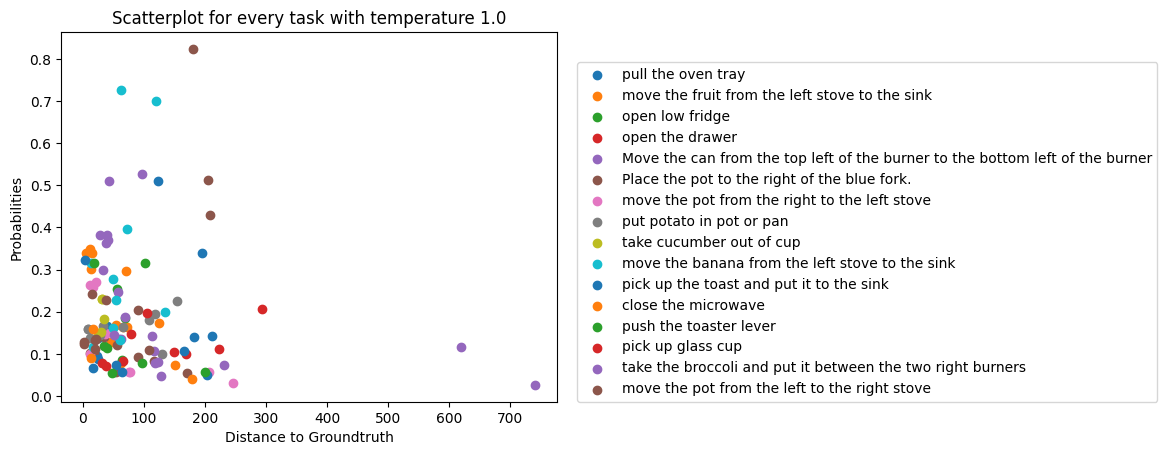

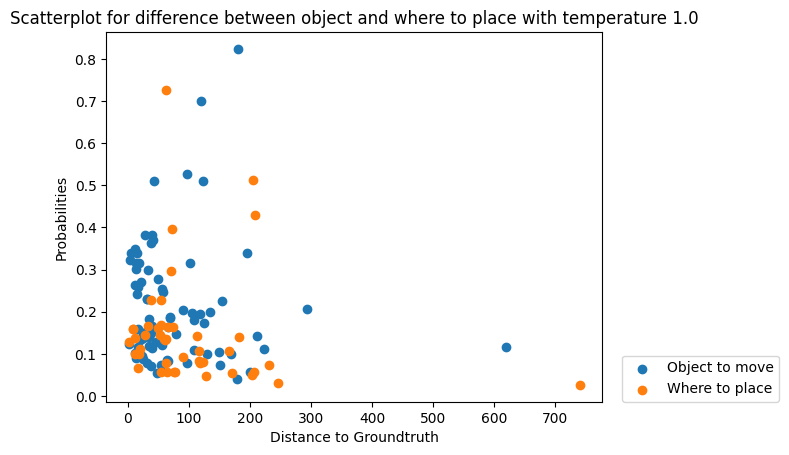

In [7]:
experiment_path = "../data/base_experiments"
num_runs = 5
temperature = 1.0

prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
prompt_ends = [" For that you have to point to the relevant object in the picture. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else.", " For that you have to point to the place in the picture where the object has to be moved to. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

run_experiment(experiment_path, prompt_starts, prompt_ends, num_runs, temperature)

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
Task: move the pot from the right to the left stove
Task: put potato in pot or pan
Task: take cucumber out of cup
Task: move the banana from the left stove to the sink
Task: pick up the toast and put it to the sink
Task: close the microwave
Task: push the toaster lever
Task: pick up glass cup
Task: take the broccoli and put it between the two right burners
Task: move the pot from the left to the right stove
Number of runs with more than one coordinate: 0


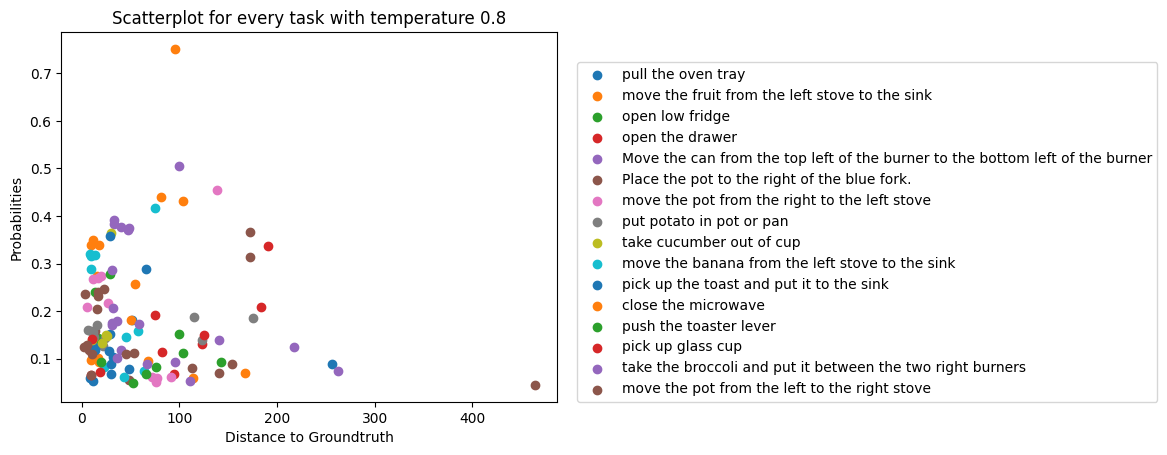

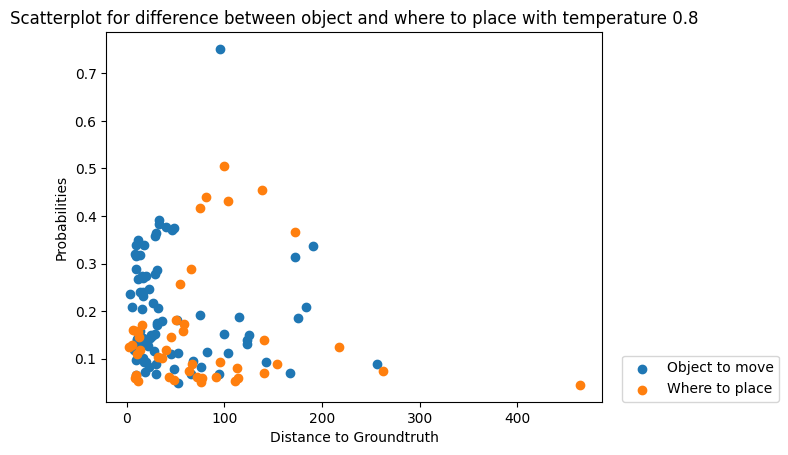

In [6]:
experiment_path = "../data/base_experiments"
num_runs = 5
temperature = 0.8

prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
prompt_ends = [" For that you have to point to the relevant object in the picture. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else.", " For that you have to point to the place in the picture where the object has to be moved to. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

run_experiment(experiment_path, prompt_starts, prompt_ends, num_runs, temperature)

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
Task: move the pot from the right to the left stove
Task: put potato in pot or pan
Task: take cucumber out of cup
Task: move the banana from the left stove to the sink
Task: pick up the toast and put it to the sink
Task: close the microwave
Task: push the toaster lever
Task: pick up glass cup
Task: take the broccoli and put it between the two right burners
Task: move the pot from the left to the right stove
Number of runs with more than one coordinate: 0


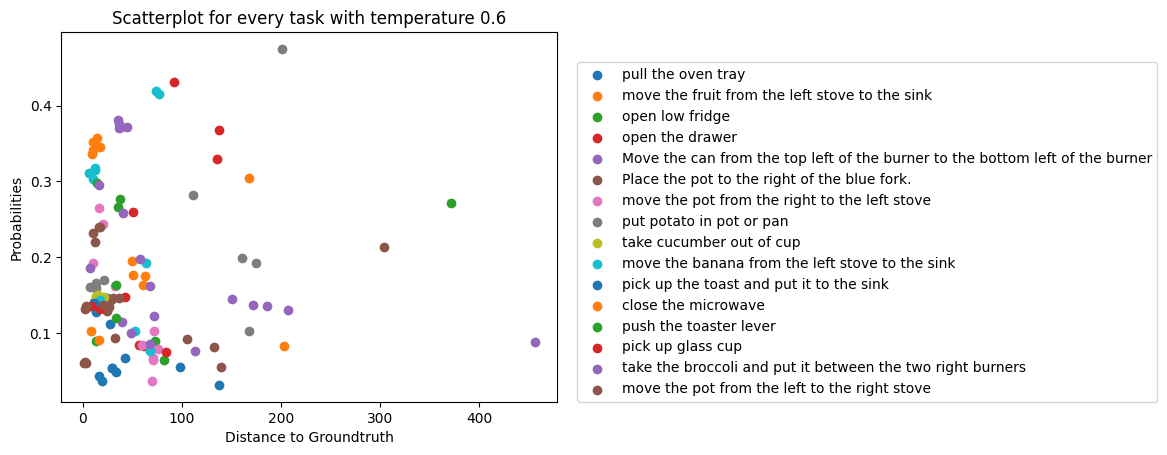

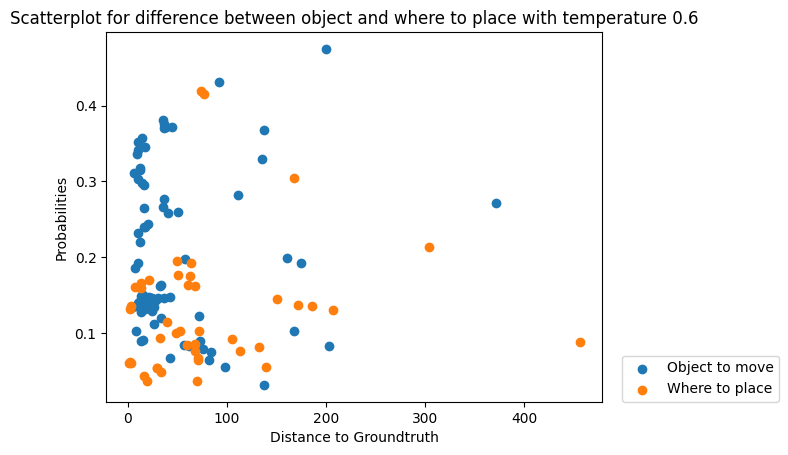

In [8]:
experiment_path = "../data/base_experiments"
num_runs = 5
temperature = 0.6

prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
prompt_ends = [" For that you have to point to the relevant object in the picture. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else.", " For that you have to point to the place in the picture where the object has to be moved to. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

run_experiment(experiment_path, prompt_starts, prompt_ends, num_runs, temperature)

In [9]:
def run_experiment_with_object(path_to_experiments, prompt_starts, prompt_ends, runs_per_task, temperature):
    tasks, images, ground_truths, objects = extract_all(path_to_experiments)
    softmax_fn = torch.nn.Softmax(dim=-1)
    
    distance_what = []
    dist_where = []
    
    prob_what = []
    prob_where = []
    
    distances_per_task = []
    probs_per_task = []
    for i in range(len(tasks)):
        task = tasks[i]
        objects_of_task = objects[i]
        ground_truth = ground_truths[i]
        prompt_what = prompt_starts[0] + task + prompt_ends[0]
        prompt_where = prompt_starts[1] + task + prompt_ends[1]
        print(f"Task: {task}")
        object = ""
    
        distances = [[],[]]
        probs = [[],[]]
    
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            prompts = [prompt_what]
            if (len(ground_truth) == 2):
                prompts.append(prompt_where)
                object = "The releveant object is: " + objects_of_task[0] + " "
    
            for k in range(len(prompts)):
                for j in range(runs_per_task):
                    output_text, output, inputs = do_inference(image, prompts[k], model, processor, temperature)
                    
                    coordinates = get_coordinates(output_text, image_width, image_height)
                    if len(coordinates) == 1:
                        euc_dist = calculate_euclidian_distance(coordinates[0], ground_truth[k])
                        coord_probs = calculate_probability_of_coordinates(output, inputs, processor)
                        
                        distances[k].append(euc_dist)
                        probs[k].append(coord_probs)
    
        # Per task output
        distances_per_task.append(distances[0] + distances[1])
        probs_per_task.append(probs[0] + probs[1])
    
        # Object to move / where to place output
        distance_what.append(distances[0])
        prob_what.append(probs[0])
        if (distances[1] != []):
            dist_where.append(distances[1])
            prob_where.append(probs[1])
        
    
    dists = [distance_what, dist_where]
    probs_2 = [prob_what, prob_where]
            
    plot_scatter(tasks, probs_per_task, distances_per_task, "Scatterplot for every task")
    plot_scatter(["Object to move", "Where to place"], probs_2, dists, "Scatterplot for difference between object and where to place")

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
Task: move the pot from the right to the left stove
Task: put potato in pot or pan
Task: take cucumber out of cup
Task: move the banana from the left stove to the sink
Task: pick up the toast and put it to the sink
Task: close the microwave
Task: push the toaster lever
Task: pick up glass cup
Task: take the broccoli and put it between the two right burners
Task: move the pot from the left to the right stove


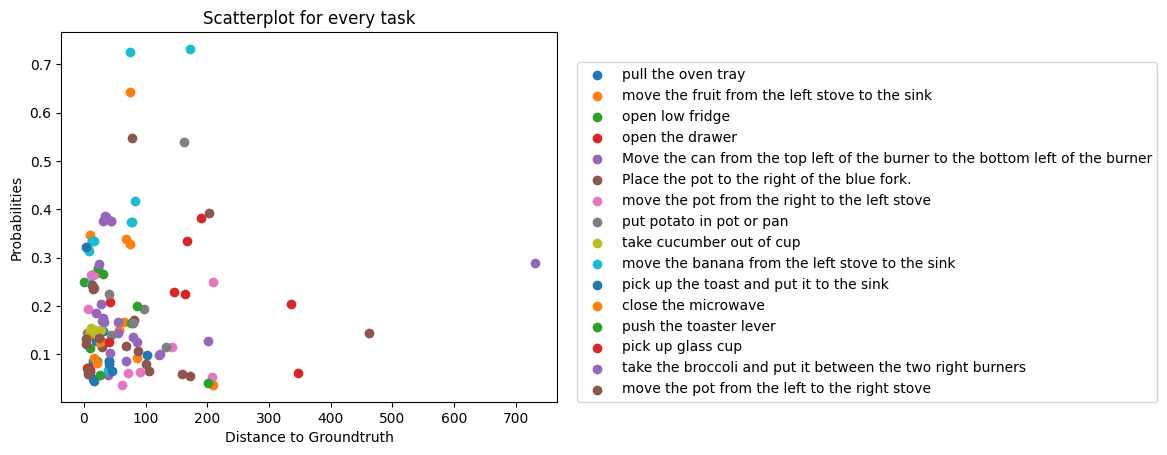

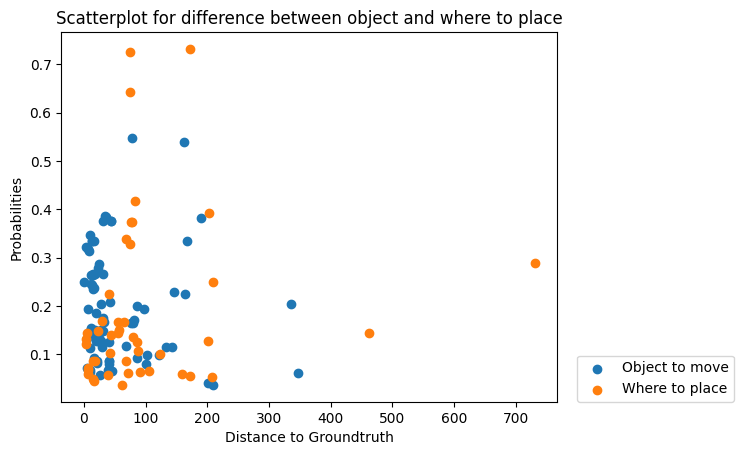

In [12]:
experiment_path = "../data/base_experiments"
num_runs = 5
temperature = 0.7

prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
prompt_ends = [" For that you have to point to the relevant object in the picture. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else.", " For that you have to point to the place in the picture where the object has to be moved to. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

run_experiment_with_object(experiment_path, prompt_starts, prompt_ends, num_runs, temperature)

In [ ]:
experiment_path = "../data/base_experiments"
num_runs = 5
temperature = 0.6

prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
prompt_ends = [" For that you have to point to the relevant object in the picture. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else.", " For that you have to point to the place in the picture where the object has to be moved to. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

run_experiment_with_object(experiment_path, prompt_starts, prompt_ends, num_runs, temperature)

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
